# **Variational AutoEncoder, a bit KL Divergence, with PyTorch**

fuente: https://medium.com/@outerrencedl/variational-autoencoder-and-a-bit-kl-divergence-with-pytorch-ce04fd55d0d7

# I. Preliminaries

In [1]:
import os

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary

import numpy as np
import torchvision
from torchvision import transforms
from torchvision import datasets

from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Project running on device: ", DEVICE)

Project running on device:  cpu


In [2]:
config = {
    "batch_size": 64,
    "epochs": 10,
    "lr": 1e-3,
    "hidden_dim": 2, # dimensiones del espacio latente
    "kl_weight":  0.3 # peso que regular la perdida entre MSE y KL divergence
}


labels = ["0",
          "1",
          "2",
          "3",
          "4",
          "5",
          "6",
          "7",
          "8",
          "9"
          ]

# II. Dataset

## Loading MNIST Dataset

In [3]:
def collate_fn(batch):

    process = transforms.Compose([
                transforms.ToTensor(),
                transforms.Pad([2])]
                )

    x = [process(data[0]) for data in batch]
    x = torch.concat(x).unsqueeze(1)

    y = torch.LongTensor([data[1] for data in batch])
    return x, y

In [4]:
%%capture

train_data = datasets.MNIST(root='./data', train=True, download=True)
valid_data = datasets.MNIST(root='./data', train=False, download=True)


train_loader = DataLoader(train_data, batch_size=config["batch_size"], shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=config["batch_size"], shuffle=False, collate_fn=collate_fn)

Inspecting train data: 
Batch shape:  torch.Size([64, 1, 32, 32])


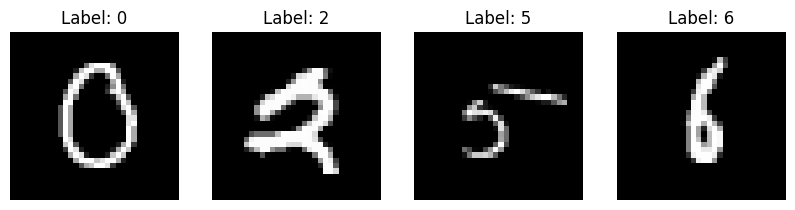

In [5]:
print("Inspecting train data: ")
for _, data in enumerate(train_loader):
    print("Batch shape: ", data[0].shape)
    fig, ax = plt.subplots(1, 4, figsize=(10, 4))
    for i in range(4):
        ax[i].imshow(data[0][i].squeeze(), cmap="gray")
        ax[i].axis("off")
        ax[i].set_title('Label: ' + str(data[1][i].numpy()))
    plt.show()
    break

# III. Variational AutoEncoder

In [6]:
# hiperparámetros del modelo
# es un autoencoder de convolución
LAYERS = 3
KERNELS = [3, 3, 3]
CHANNELS = [32, 64, 128]
STRIDES = [2, 2, 2]
LINEAR_DIM = 2048


## Encoder

In [7]:
class Encoder(nn.Module):

    def __init__(self, output_dim=2, use_batchnorm=False, use_dropout=False):
        super(Encoder, self).__init__()

        # bottleneck dimentionality
        self.output_dim = output_dim

        # variables deciding if using dropout and batchnorm in model
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm

        # convolutional layer hyper parameters
        self.layers = LAYERS
        self.kernels = KERNELS
        self.channels = CHANNELS
        self.strides = STRIDES
        self.conv = self.get_convs()

        self.flatten = nn.Flatten()

        # Adding mean and sigma projections
        self.mu = nn.Linear(2048, self.output_dim)
        self.sigma = nn.Linear(2048, self.output_dim)

        # Initialize a 'target' normal distribution for KL divergence
        self.norm = torch.distributions.Normal(0, 1)

        # tracking the KL divergence
        self.kl = 0


    def get_convs(self):
        model = nn.Sequential()
        for i in range(self.layers):

            if i == 0: model.append(nn.Conv2d(1,
                                              self.channels[i],
                                              kernel_size=self.kernels[i],
                                              stride=self.strides[i],
                                              padding=1))

            else: model.append(nn.Conv2d(self.channels[i-1],
                                         self.channels[i],
                                         kernel_size=self.kernels[i],
                                         stride=self.strides[i],
                                         padding=1))

            if self.use_batchnorm:
                model.append(nn.BatchNorm2d(self.channels[i]))

            #model.append(nn.GELU()) # Here we use GELU as activation function
            model.append(nn.Tanh()) # Here we use Tanh as activation function

            if self.use_dropout:
                model.append(nn.Dropout2d(0.25))

        return model


    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)

        # getting mean/sigma projections
        x_mu = self.mu(x)
        x_sigma = torch.exp(self.sigma(x))

        # reparameterization trick
        z = x_mu + x_sigma * self.norm.sample(x_mu.shape).to(DEVICE)

        # compute the KL divergence and store in the class
        self.kl = (x_sigma ** 2 + x_mu ** 2
                    - torch.log(x_sigma) - 0.5).sum()

        return z # we only return the sample points to feed to the decoder


encoder = Encoder(use_batchnorm=True, use_dropout=True).to(DEVICE)
summary(encoder, (1, 32, 32))
pass

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              Tanh-3           [-1, 32, 16, 16]               0
         Dropout2d-4           [-1, 32, 16, 16]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              Tanh-7             [-1, 64, 8, 8]               0
         Dropout2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 4, 4]          73,856
      BatchNorm2d-10            [-1, 128, 4, 4]             256
             Tanh-11            [-1, 128, 4, 4]               0
        Dropout2d-12            [-1, 128, 4, 4]               0
          Flatten-13                 [-1, 2048]               0
           Linear-14                   

## Decoder

In [8]:
class Decoder(nn.Module):
    def __init__(self, input_dim=2, use_batchnorm=False, use_dropout=False):
        super(Decoder, self).__init__()

        # variables deciding if using dropout and batchnorm in model
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm

        self.fc_dim = LINEAR_DIM
        self.input_dim = input_dim

        # Conv layer hypyer parameters
        self.layers = LAYERS
        self.kernels = KERNELS
        self.channels = CHANNELS[::-1] # flip the channel dimensions
        self.strides = STRIDES

        # In decoder, we first do fc project, then conv layers
        self.linear = nn.Linear(self.input_dim, self.fc_dim)
        self.conv =  self.get_convs()

        self.output = nn.Conv2d(self.channels[-1], 1, kernel_size=1, stride=1)


    def get_convs(self):
        conv_layers = nn.Sequential()
        for i in range(self.layers):

            if i == 0: conv_layers.append(
                            nn.ConvTranspose2d(self.channels[i],
                                               self.channels[i],
                                               kernel_size=self.kernels[i],
                                               stride=self.strides[i],
                                               padding=1,
                                               output_padding=1)
                            )

            else: conv_layers.append(
                            nn.ConvTranspose2d(self.channels[i-1],
                                               self.channels[i],
                                               kernel_size=self.kernels[i],
                                               stride=self.strides[i],
                                               padding=1,
                                               output_padding=1
                                              )
                            )

            if self.use_batchnorm and i != self.layers - 1:
                conv_layers.append(nn.BatchNorm2d(self.channels[i]))

            #conv_layers.append(nn.GELU())
            conv_layers.append(nn.Tanh())

            if self.use_dropout:
                conv_layers.append(nn.Dropout2d(0.15))

        return conv_layers


    def forward(self, x):
        x = self.linear(x)
        # reshape 3D tensor to 4D tensor
        x = x.reshape(x.shape[0], 128, 4, 4)
        x = self.conv(x)
        return self.output(x)

decoder = Decoder(use_batchnorm=True, use_dropout=True).to(DEVICE)
summary(decoder, (1, 2))
pass

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 2048]           6,144
   ConvTranspose2d-2            [-1, 128, 8, 8]         147,584
       BatchNorm2d-3            [-1, 128, 8, 8]             256
              Tanh-4            [-1, 128, 8, 8]               0
         Dropout2d-5            [-1, 128, 8, 8]               0
   ConvTranspose2d-6           [-1, 64, 16, 16]          73,792
       BatchNorm2d-7           [-1, 64, 16, 16]             128
              Tanh-8           [-1, 64, 16, 16]               0
         Dropout2d-9           [-1, 64, 16, 16]               0
  ConvTranspose2d-10           [-1, 32, 32, 32]          18,464
             Tanh-11           [-1, 32, 32, 32]               0
        Dropout2d-12           [-1, 32, 32, 32]               0
           Conv2d-13            [-1, 1, 32, 32]              33
Total params: 246,401
Trainable params:

## Variational AutoEncoder

In [9]:
class AutoEncoder(nn.Module):

    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(output_dim=config["hidden_dim"], use_batchnorm=True, use_dropout=False)
        self.decoder = Decoder(input_dim=config["hidden_dim"], use_batchnorm=True, use_dropout=False)

    def forward(self, x):
        x = self.encoder(x)
        reconst = self.decoder(x)
        return reconst

model = AutoEncoder().to(DEVICE)
summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              Tanh-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          18,496
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              Tanh-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
       BatchNorm2d-8            [-1, 128, 4, 4]             256
              Tanh-9            [-1, 128, 4, 4]               0
          Flatten-10                 [-1, 2048]               0
           Linear-11                    [-1, 2]           4,098
           Linear-12                    [-1, 2]           4,098
          Encoder-13                    [-1, 2]               0
           Linear-14                 [-

In [10]:
# esta ruta es el colab mismo.. al cerrar la sesion se pierden los archivos

direccion = '/content'
model.load_state_dict(torch.load(os.path.join(direccion, "VAE_autoencoder_tanh_kl_03(1).pt"), map_location = DEVICE))


<All keys matched successfully>

# IV. Experiment

## Training setup

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()
steps = 0

/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [ ]:


def train(model, dataloader, optimizer, save_distrib=False):
    global steps

    model.train()
    train_loss = 0.0

    # Process tqdm bar
    batch_bar = tqdm(total=len(dataloader),
                     leave=False, position=0, desc="Train")

    for i, batch in enumerate(dataloader):

        optimizer.zero_grad()
        x = batch[0].to(DEVICE)

        with torch.cuda.amp.autocast():
            # get reconstruct image
            x_hat = model(x)
            # MSE loss between original image and reconstructed one
            loss_mse = ((x - x_hat)**2).sum() / config["batch_size"]
            # KL divergence between encoder distrib. and N(0,1) distrib.
            loss_kl = model.encoder.kl / config["batch_size"]
            # Get weighted loss
            loss = (loss_mse * (1 - config["kl_weight"])+ loss_kl * config["kl_weight"])

            #loss = loss_mse + 1*loss_kl


        train_loss += loss.item()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()


        batch_bar.set_postfix(
            loss = f"{train_loss/(i+1):.4f}",
            mse_loss = f"{loss_mse:.4f}",
            kl_loss = f"{loss_kl:.4f}",
            lr = f"{optimizer.param_groups[0]['lr']:.4f}"
        )

        batch_bar.update()
        torch.cuda.empty_cache()
        del x, x_hat

    batch_bar.close()
    train_loss /= len(dataloader)

    return train_loss

In [ ]:
def validate(model, dataloader):

    model.eval()
    valid_loss = 0.0

    # Progress tqdm bar
    batch_bar = tqdm(total=len(dataloader),
                     leave=False, position=0, desc="Validation")

    for i, batch in enumerate(dataloader):
        x = batch[0].to(DEVICE)

        with torch.no_grad():
            x_hat = model(x)
        loss_mse = ((x - x_hat)**2).sum() / config["batch_size"]
        loss_kl = model.encoder.kl / config["batch_size"]
        loss = loss_mse * (1 - config["kl_weight"]) + loss_kl * config["kl_weight"]
        #loss = loss_mse + 1*loss_kl

        valid_loss += loss.item()

        batch_bar.set_postfix(
            loss = f"{train_loss/(i+1):.4f}",
            mse_loss = f"{loss_mse:.4f}",
            kl_loss = f"{loss_kl:.4f}",
            lr = f"{optimizer.param_groups[0]['lr']:.4f}"
        )

        batch_bar.update()
        torch.cuda.empty_cache()
        del x, x_hat

    batch_bar.close()
    valid_loss /= len(dataloader)

    return valid_loss

In [ ]:
# Train the model
train_loss_hist = []
valid_loss_hist = []
global BEST_VAL
BEST_VAL = float('inf')     # record the best val loss
MODEL_NAME = 'vae_autoencoder'

for i in range(config["epochs"]):
    curr_lr = float(optimizer.param_groups[0]["lr"])
    train_loss = train(model, train_loader, optimizer, save_distrib=False)
    valid_loss = validate(model, valid_loader)
    train_loss_hist.append(train_loss)
    valid_loss_hist.append(valid_loss)
    print(f"Epoch {i+1}/{config['epochs']}: \t Train loss: {train_loss:.4f}\t Validation loss: {valid_loss:.4f}\tlr: {curr_lr:.4f}")


    if valid_loss < BEST_VAL:
        BEST_VAL = valid_loss
        torch.save(model.state_dict(), os.path.join(direccion, MODEL_NAME + ".pt"))
        print('Save Best Model in HISTORY\n')

Train:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1/10: 	 Train loss: 60.3386	 Validation loss: 73.6022	lr: 0.0010
Save Best Model in HISTORY



Epoch 2/10: 	 Train loss: 59.7715	 Validation loss: 73.8296	lr: 0.0010


Epoch 3/10: 	 Train loss: 59.7476	 Validation loss: 73.4789	lr: 0.0010
Save Best Model in HISTORY



Train:  49%|████▉     | 460/938 [02:10<02:07,  3.76it/s, kl_loss=0.6957, loss=59.7815, lr=0.0010, mse_loss=52.5656]

KeyboardInterrupt: 

## Cargar modelo ya entrenado

In [ ]:
model.load_state_dict(torch.load(os.path.join(direccion, MODEL_NAME + ".pt"), map_location = DEVICE))

<All keys matched successfully>

## Analysis

ValueError: x and y must have same first dimension, but have shapes (10,) and (5,)

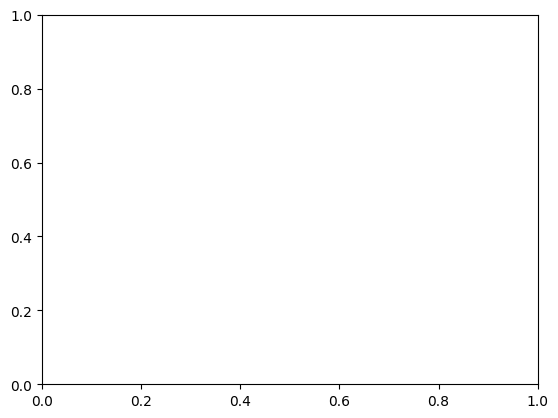

In [ ]:
def plot_hist():
    x_seq = list(range(config["epochs"]))
    plt.plot(x_seq, train_loss_hist, label="Train Loss")
    plt.plot(x_seq, valid_loss_hist, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_hist()

In [11]:
def show_plot():

    model.eval()

    points = []
    labels_idx = []

    for i, data in enumerate(valid_loader):
        img, label = [d.to(DEVICE) for d in data]
        z = model.encoder(img)
        points.extend(z.detach().cpu().numpy())
        labels_idx.extend(label.detach().cpu().numpy())
        del img, label

    points = np.array(points)
    labels_idx = np.array(labels_idx)


    plt.figure(figsize=(10, 9))
    plt.title(f"KL Weight = {config['kl_weight']}, MSE Weight = {1 - config['kl_weight']:.2f}")
    c_map = matplotlib.cm.get_cmap("tab10")

    for i, label in enumerate(labels):
        filters = np.where(labels_idx==i)
        pts = points[filters]
        lbs = labels_idx[filters]

        col = [c_map(i)] * len(pts)

        plt.scatter(x=pts[:, 0], y=pts[:, 1], s=2.0,
                     c=col, alpha=0.9, zorder=2, label=label)
        plt.grid(True, color="lightgray", alpha=1.0, zorder=0)

    plt.legend(markerscale=4.0)
    plt.show()

<ipython-input-11-1c72e8133d5f>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c_map = matplotlib.cm.get_cmap("tab10")


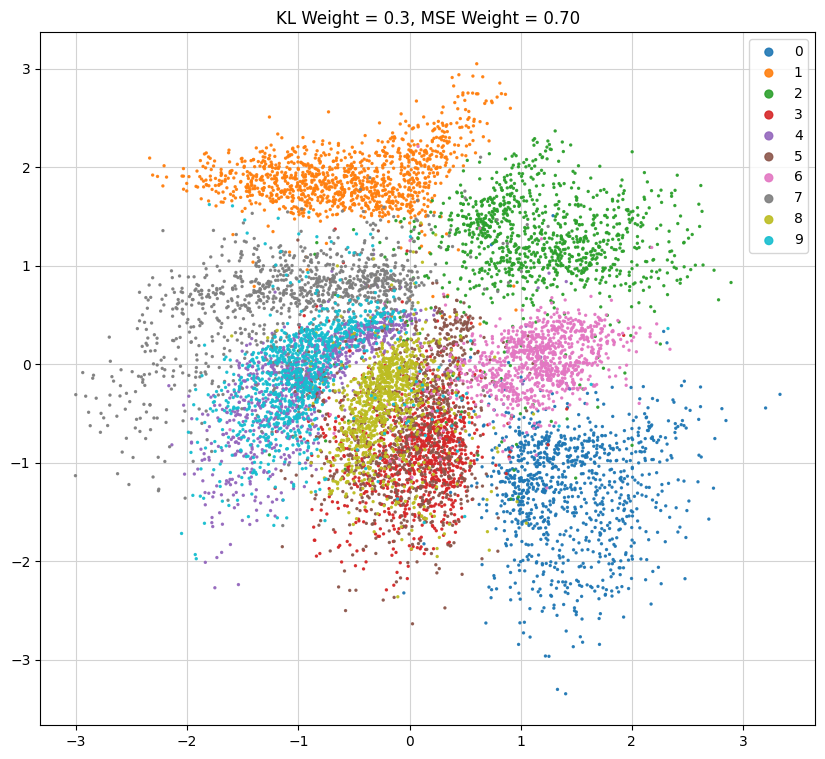

In [12]:
show_plot()

# V. Interpolation

In [ ]:
def interpolate(class_a:int, class_b:int, num_steps:int):
    model.eval()

    step_size = 1.0 / num_steps

    sample_a = None
    sample_b = None

    # retriving data that corresponded to the class indices
    for i, data in enumerate(train_loader):
        img, label = data
        sample_a = img[label==class_a] if sample_a == None else sample_a
        sample_b = img[label==class_b] if sample_b == None else sample_b
        if len(sample_a) != 0 and len(sample_b) != 0:
            break

    # encoding both images to get sampled z values of both classes
    with torch.no_grad():
        z_a = model.encoder(sample_a.to(DEVICE))[0].reshape(1, -1)
        z_b = model.encoder(sample_b.to(DEVICE))[0].reshape(1, -1)

    print("z_a: ", z_a)
    print("z_b: ", z_b)

    # interpolation
    diff = z_b - z_a
    steps = torch.arange(0.0, 1.0 + step_size, step_size,
                        dtype=torch.float, device=z_a.device).reshape(-1, 1)
    zs = z_a + steps * diff

    with torch.no_grad():
        out_imgs = model.decoder(zs)

    # flatten images
    out_imgs = out_imgs.permute(0, 1, 3, 2)
    out_imgs = out_imgs.detach().cpu().numpy().reshape(-1, 32).T

    return out_imgs

In [ ]:
class_a = 0
class_b = 7
num_steps = 15

interp_imgs = interpolate(class_a, class_b, num_steps)

plt.figure(figsize=(16, 10))
plt.title(f"Interpolation between class \"{labels[class_a]}\" and \"{labels[class_b]}\"")
plt.imshow(interp_imgs, cmap="gray")
plt.axis("off")
plt.show()